# Sample Notebook working with PyTorch 3d

This simple note book takes in the teapot.obj geometry and optimizes the camera angle.


In [1]:
# initial setup. Install pytorch crap and fetch dataset from github
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

!mkdir -p data
!wget -P data https://github.com/daviesthomas/MaterialMapping/releases/download/0.0.1/teapotDataset.zip
from zipfile import ZipFile
with ZipFile('data/teapotDataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('data')
#TODO: stop posting this crap with datasets...
!rm -r data/__MACOSX

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-g94guf_h
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-g94guf_h
  Running command git checkout -q cf8e667b614d82194cf2c806ace87473b7d807ac
  Created wheel for pytorch3d: filename=pytorch3d-0.1.1-cp36-cp36m-linux_x86_64.whl size=5981671 sha256=15403094ba450f9092306de0d35e4e2ed17b7ed8ca29fda158f0bfc160c947c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bpe1zgqa/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
Successfully built pytorch3d
--2020-04-02 01:41:29--  https://github.com/daviesthomas/MaterialMapping/releases/download/0.0.1/teapotDataset.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github-production-release-asset-2e65be.s3.amazonaws.com/244393841/e0204c80-74

## Main Code

In [81]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
from tqdm import tqdm_notebook
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, SoftPhongShader, PointLights, Materials, DirectionalLights
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
# Set the cuda device 
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("./data/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [0]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device, fov=45)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0,#np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)
# We can add a point light in front of the object. 
lights = DirectionalLights(device=device, direction=((0.0, 1.0, 0.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights)
)

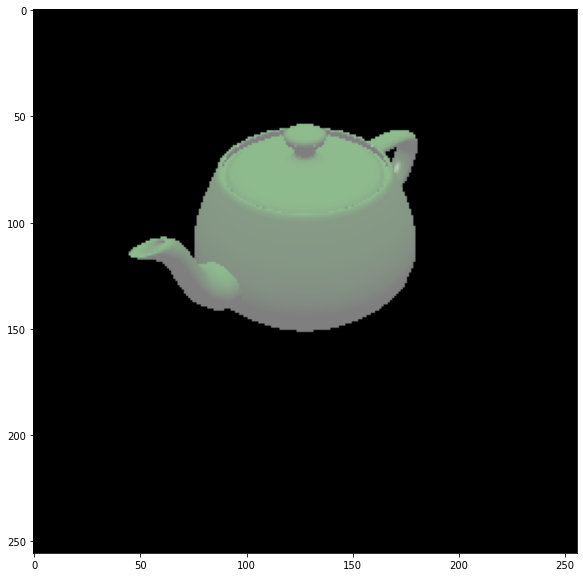

In [185]:
# Select the viewpoint using spherical angles  
distance = 4  # distance from camera to the object
elevation = 40.0   # angle of elevation in degrees
azimuth = 135.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# sample random material... (no significance to any params)
material = Materials(
    ambient_color=((1,1,1),), 
    diffuse_color=((0.2,0.8,0.2),),
    specular_color=((1,1,1),),
    shininess= 64,
    device=device
    )

# Render the teapot providing the values of R and T. 
baseRender = phong_renderer(meshes_world=teapot_mesh, R=R, T=T, materials=material)

image_ref = baseRender.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(image_ref.squeeze())
plt.grid(False)

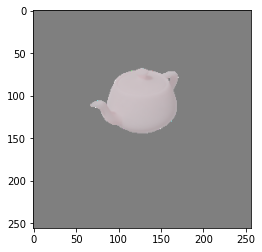

In [213]:
import torchvision

def loadRenderDataset(dataPath, batchSize=8):
    dataset = torchvision.datasets.ImageFolder(
        root = dataPath,
        transform=torchvision.transforms.ToTensor()
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batchSize,
        num_workers=0,
        shuffle=True
    )
    return loader

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imcompare(generated, target):
    im1 = generated / 2 + 0.5     # unnormalize
    im2 = target / 2 + 0.5

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(im1.numpy(), (1, 2, 0)))
    plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(im2.numpy(), (1, 2, 0)))
    plt.grid(False)

    plt.show()

renderLoader= loadRenderDataset('data', batchSize=1)

# get some random training images
dataiter = iter(renderLoader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
def conv(in_channels, out_channels, kernel_size, stride=1, padding=2, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(
        in_channels=in_channels, 
        out_channels=out_channels, 
        kernel_size=kernel_size, 
        stride=stride, 
        padding=padding, 
        bias=True
    )
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def dense(in_features, out_features, batch_norm=False):
  layers = []

  layers.append(nn.Linear(in_features, out_features, bias=True))

  if batch_norm:
    layers.append(nn.BatchNorm1d(out_features))

  return nn.Sequential(*layers)

class RenderingModel(nn.Module):
    def __init__(self, mesh, renderer):
        super().__init__()
        self.mesh = mesh
        self.device = mesh.device
        self.renderer = renderer

        # easy toggle for what params to predict. 
        self.paramsToPredict = {
          'camPos' : 3,
          'ambient': 3,
          'diffuse': 3,
          'specular': 3,
          'shininess': 0
        }

        self.pool = nn.MaxPool2d(2,2)

        self.conv1 = conv(3,16,5,padding=2, batch_norm=True)
        self.conv2 = conv(16,32,5,padding=2, batch_norm=True)
        self.conv3 = conv(32,64,5,padding=2, batch_norm=True)
        self.conv4 = conv(64,128,5,padding=2, batch_norm=True)
        self.conv5 = conv(128,256,5,padding=2, batch_norm=True)
        self.conv6 = conv(256,512,3,padding=1, batch_norm=True)
        self.conv7 = conv(512,1024,3,padding=1, batch_norm=True)

        self.fc1 = dense(1024*2*2, 512)
        self.fc2 = dense(512,256)
        self.fc3 = dense(256, sum(list(self.paramsToPredict.values())), False)
    
    def convertToRenderParams(self, x):        
        splits = [k for k in list(self.paramsToPredict.values()) if k > 0]
        paramArray = torch.split(x, splits, dim=1)

        p = 0 
        if (self.paramsToPredict['camPos'] > 0):
          camPosition = paramArray[p]*5
          print(camPosition)
          R = look_at_rotation(camPosition, device=self.device)
          T = -torch.bmm(
              R.transpose(1, 2), 
              camPosition[:, :, None])[:, :, 0].to(self.device)
          p += 1
        else:
          distance = 4  # distance from camera to the object
          elevation = 40.0   # angle of elevation in degrees
          azimuth = 135.0  # No rotation so the camera is positioned on the +Z axis. 

          # Get the position of the camera based on the spherical angles
          R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
    
        if (self.paramsToPredict['ambient'] > 0):
          ambientColor = paramArray[p] 
          p += 1
        else:
          ambientColor = ((1, 1, 1),)

        if (self.paramsToPredict['diffuse'] > 0):
          diffuseColor = paramArray[p]
          p += 1
        else:
          diffuseColor = ((1, 1, 1),)

        if (self.paramsToPredict['specular'] > 0):
          specularColor = paramArray[p]
          p += 1
        else:
          specularColor = ((1, 1, 1),)

        if (self.paramsToPredict['shininess'] > 0):
          shininess = paramArray[p].squeeze()
        else:
          shininess = 64

        return {
          'R' : R,
          'T' : T,
          'ambientColor': ambientColor,
          'specularColor': specularColor,
          'diffuseColor': diffuseColor,
          'shininess': shininess
        }



    def forward(self, x):
        # x: # BxCxHxW
        x = F.relu(self.conv1(x)) # Bx16x256x256
        x = self.pool(x)  # Bx16x128x128

        x = F.relu(self.conv2(x)) # Bx32x128x128
        x = self.pool(x)  # Bx32x64x64

        x = F.relu(self.conv3(x)) # Bx64x64x64
        x = self.pool(x)  # Bx64x32x32

        x = F.relu(self.conv4(x)) # Bx128x32x32
        x = self.pool(x)  # Bx128x16x16

        x = F.relu(self.conv5(x)) # Bx256x16x16
        x = self.pool(x)  # Bx256x8x8

        x = F.relu(self.conv6(x)) # Bx512x8x8
        x = self.pool(x)  # Bx512x4x4

        x = F.relu(self.conv7(x)) # Bx1024x4x4
        x = self.pool(x)  # Bx1024x2x2

        print(x.shape)

        x = x.view(x.size(0), -1) # flatten: Bx1024*2*2

        x = F.relu(self.fc1(x))     # Bx512
        x = F.relu(self.fc2(x))     # Bx256
        x = F.sigmoid(self.fc3(x))  # BxK

        params = self.convertToRenderParams(x)

        materials = Materials(
            ambient_color = params['ambientColor'],
            diffuse_color = params['diffuseColor'],
            specular_color = params['specularColor'],
            shininess = params['shininess']*1000,
            device=self.device
        )

        image = self.renderer(
            meshes_world=self.mesh.clone(), 
            R=params['R'], 
            T=params['T'], 
            materials=materials, 
            device=self.device
        ).permute(0,3,1,2)

        return image

In [298]:
# We will save images periodically and compose them into a GIF.
filename_output = "./teapot_optimization.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = RenderingModel(mesh=teapot_mesh.extend(1), renderer=phong_renderer).to(device)
print(model)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Create loss :) For now just L2 between target and input
criterion = nn.L1Loss()

RenderingModel(
  (renderer): MeshRenderer(
    (rasterizer): MeshRasterizer()
    (shader): HardPhongShader()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Con

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1, 1024, 2, 2])
tensor([[2.5829, 2.6263, 2.2685]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


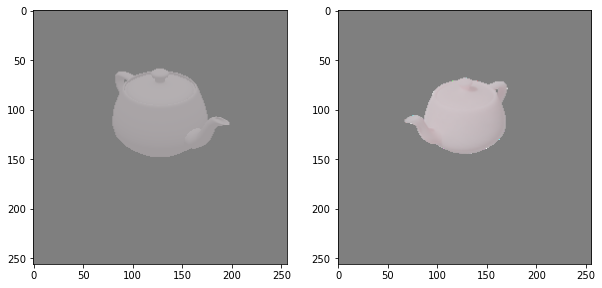

torch.Size([1, 1024, 2, 2])
tensor([[1.9674, 2.4457, 1.7813]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


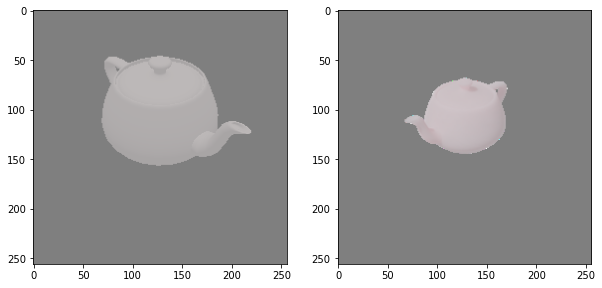

torch.Size([1, 1024, 2, 2])
tensor([[1.8747, 1.4201, 1.8781]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


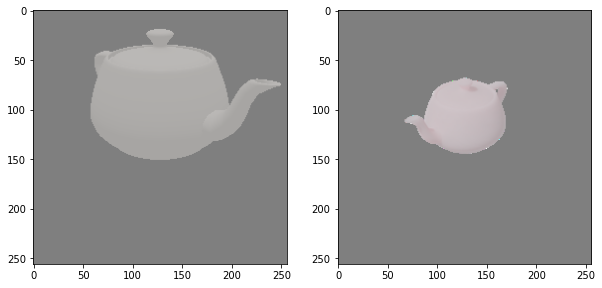

torch.Size([1, 1024, 2, 2])
tensor([[1.4783, 0.8354, 1.5340]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


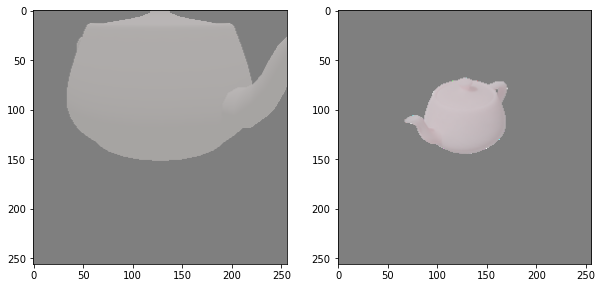

torch.Size([1, 1024, 2, 2])
tensor([[1.2809, 0.5758, 1.2515]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


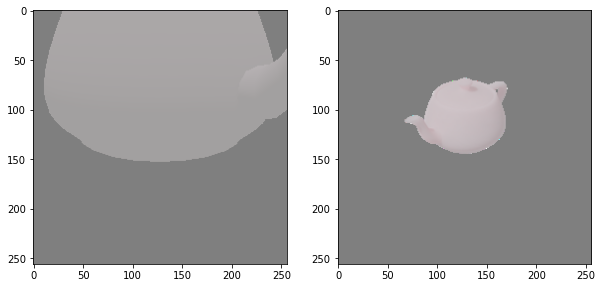

torch.Size([1, 1024, 2, 2])
tensor([[1.2199, 0.4781, 1.1319]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


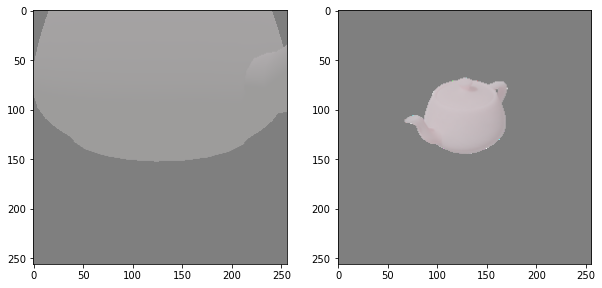

torch.Size([1, 1024, 2, 2])
tensor([[1.1825, 0.4034, 0.9998]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


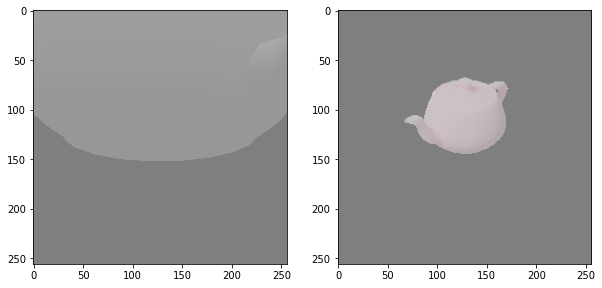

torch.Size([1, 1024, 2, 2])
tensor([[1.0744, 0.3227, 0.8358]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


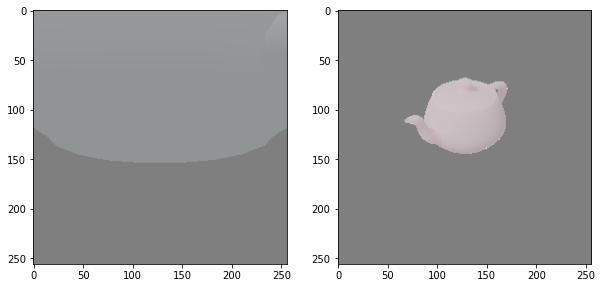

torch.Size([1, 1024, 2, 2])
tensor([[0.8675, 0.2525, 0.6877]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


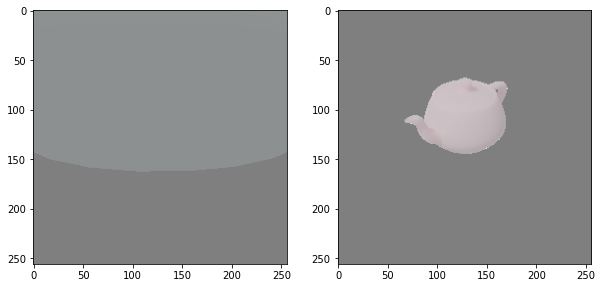

torch.Size([1, 1024, 2, 2])
tensor([[0.6789, 0.2146, 0.5649]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


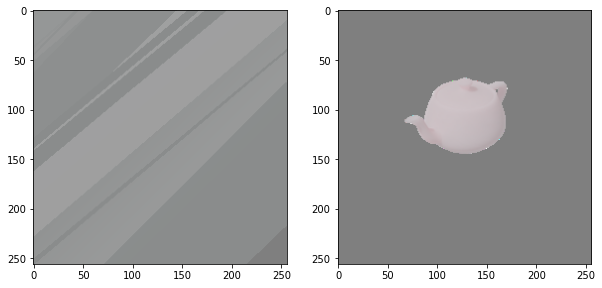

torch.Size([1, 1024, 2, 2])
tensor([[0.9064, 0.2113, 0.9038]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


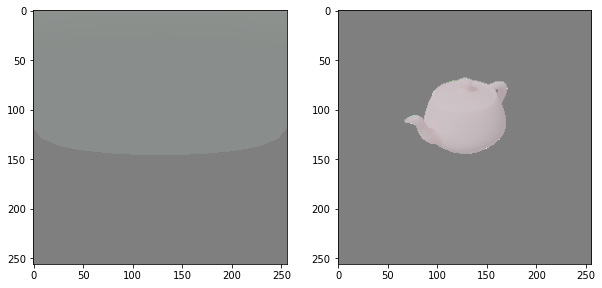

torch.Size([1, 1024, 2, 2])
tensor([[1.0864, 0.2166, 1.2189]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


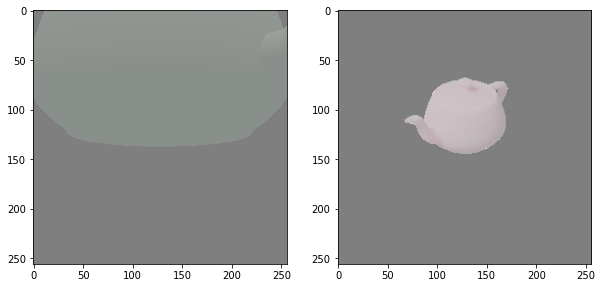

torch.Size([1, 1024, 2, 2])
tensor([[1.2298, 0.2202, 1.4342]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


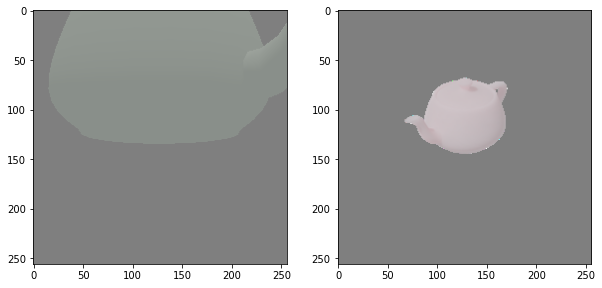

torch.Size([1, 1024, 2, 2])
tensor([[1.3336, 0.2212, 1.5760]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


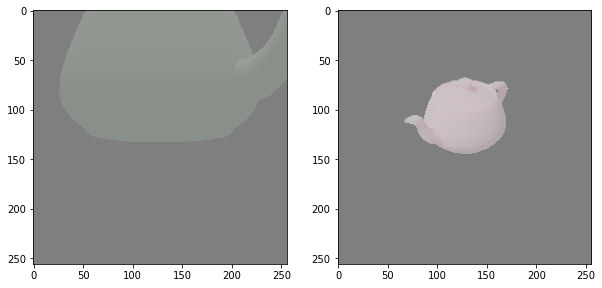

torch.Size([1, 1024, 2, 2])
tensor([[1.4131, 0.2218, 1.6578]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


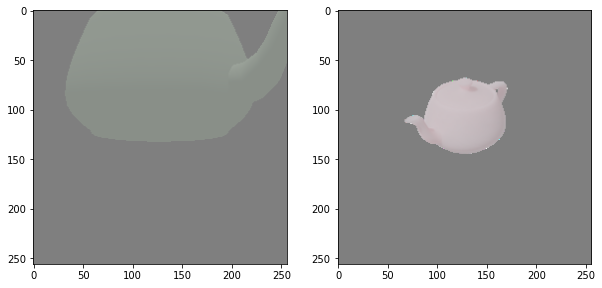

torch.Size([1, 1024, 2, 2])
tensor([[1.4736, 0.2245, 1.6883]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


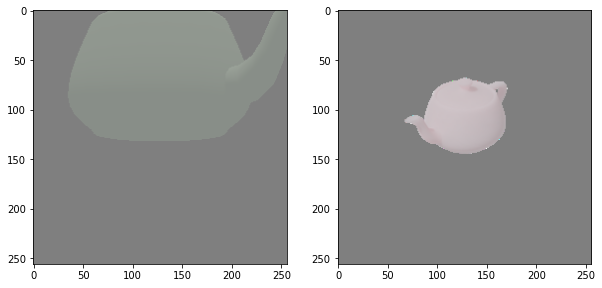

torch.Size([1, 1024, 2, 2])
tensor([[1.5242, 0.2270, 1.6848]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


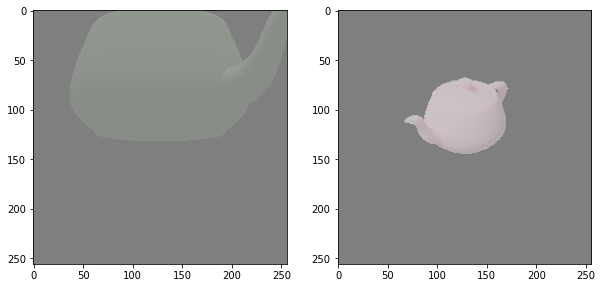

torch.Size([1, 1024, 2, 2])
tensor([[1.5607, 0.2294, 1.6511]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


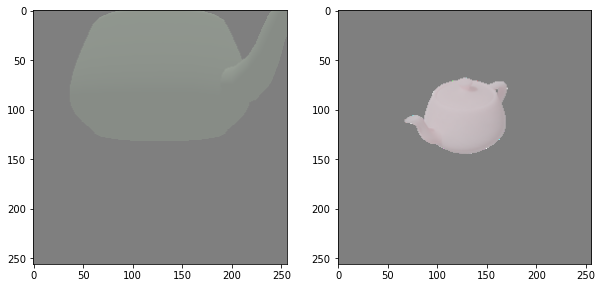

torch.Size([1, 1024, 2, 2])
tensor([[1.5816, 0.2315, 1.5940]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


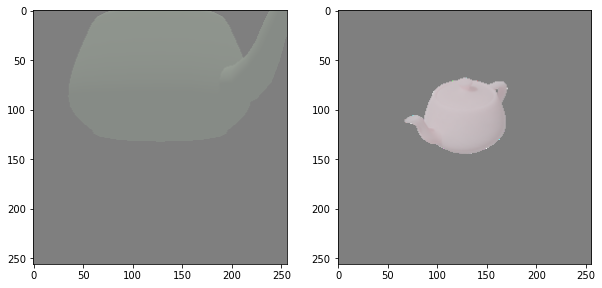

torch.Size([1, 1024, 2, 2])
tensor([[1.5914, 0.2328, 1.5192]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


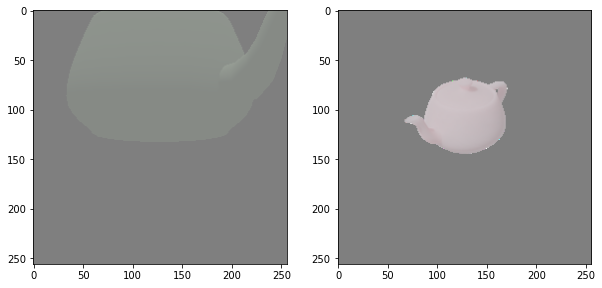

torch.Size([1, 1024, 2, 2])
tensor([[1.5900, 0.2318, 1.4370]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


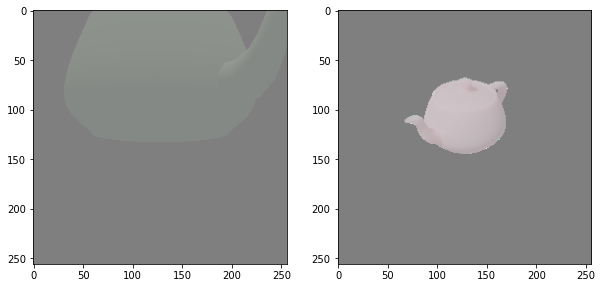

torch.Size([1, 1024, 2, 2])
tensor([[1.5809, 0.2291, 1.3441]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


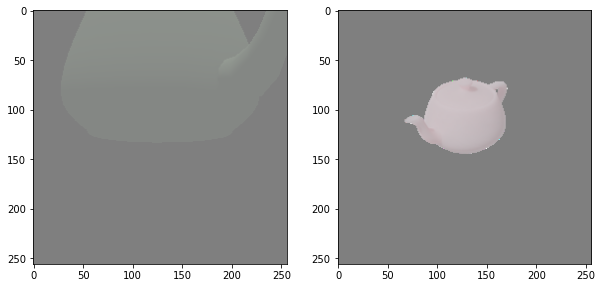

torch.Size([1, 1024, 2, 2])
tensor([[1.5659, 0.2213, 1.2342]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


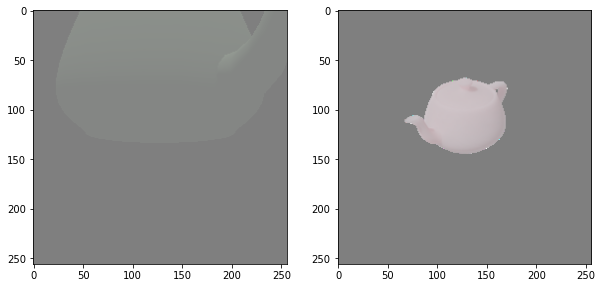

torch.Size([1, 1024, 2, 2])
tensor([[1.5455, 0.2119, 1.1186]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


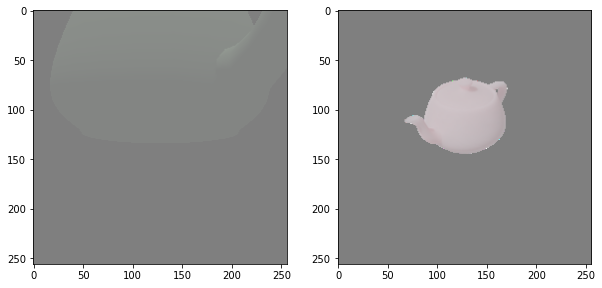

torch.Size([1, 1024, 2, 2])
tensor([[1.5213, 0.2017, 0.9995]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


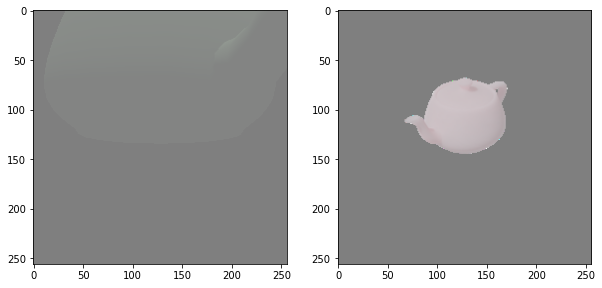

torch.Size([1, 1024, 2, 2])
tensor([[1.4827, 0.1903, 0.8799]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


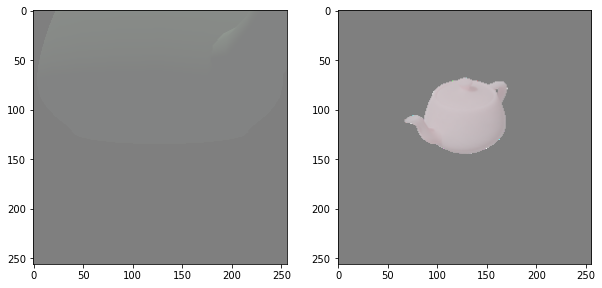

torch.Size([1, 1024, 2, 2])
tensor([[1.4243, 0.1782, 0.7659]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


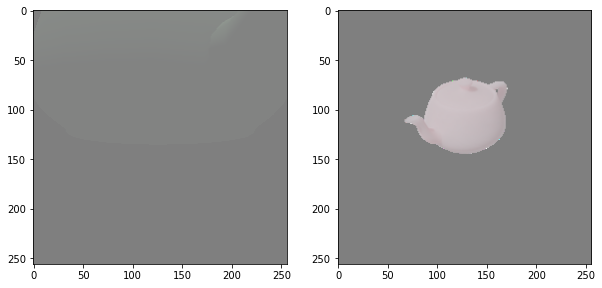

torch.Size([1, 1024, 2, 2])
tensor([[1.3387, 0.1649, 0.6678]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


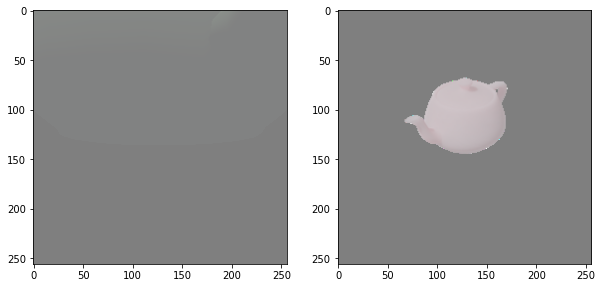

torch.Size([1, 1024, 2, 2])
tensor([[1.2243, 0.1528, 0.5801]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


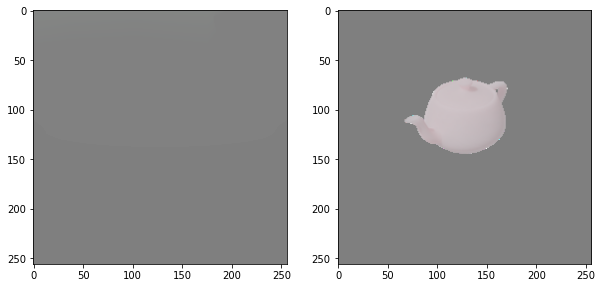

torch.Size([1, 1024, 2, 2])
tensor([[1.0901, 0.1406, 0.5066]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


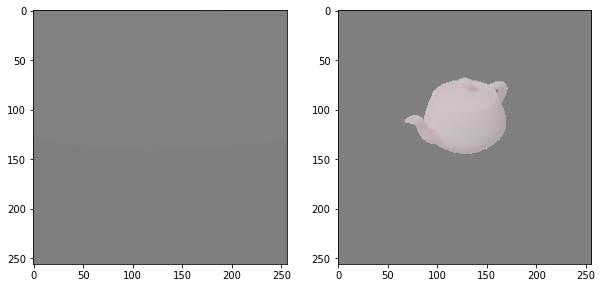

torch.Size([1, 1024, 2, 2])
tensor([[0.9746, 0.1306, 0.4443]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


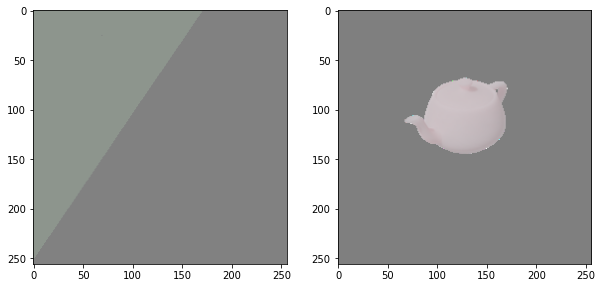

torch.Size([1, 1024, 2, 2])
tensor([[1.0649, 0.1181, 0.4224]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


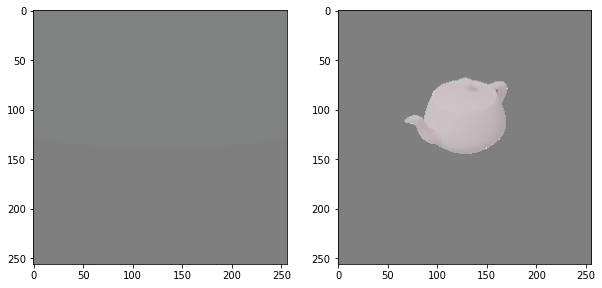

torch.Size([1, 1024, 2, 2])
tensor([[1.1511, 0.1081, 0.4016]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


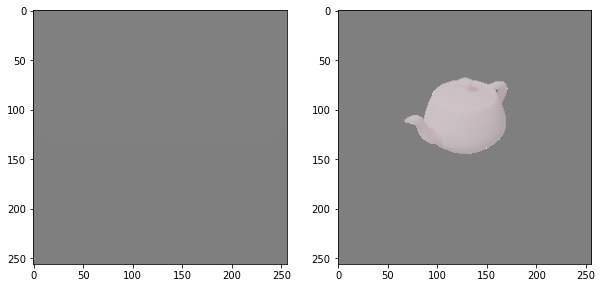

torch.Size([1, 1024, 2, 2])
tensor([[1.2320, 0.1000, 0.3821]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


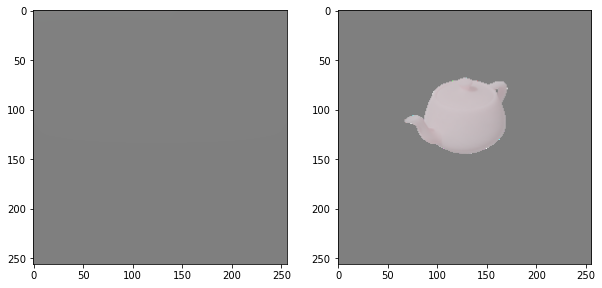

torch.Size([1, 1024, 2, 2])
tensor([[1.2967, 0.0931, 0.3648]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


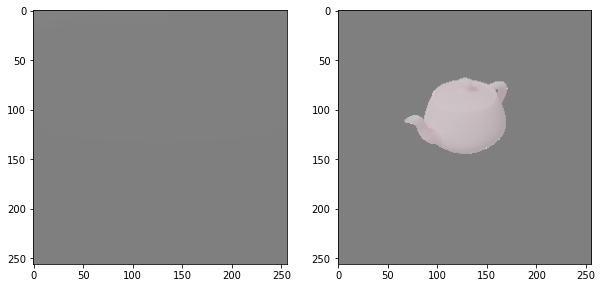

torch.Size([1, 1024, 2, 2])
tensor([[1.3406, 0.0870, 0.3492]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


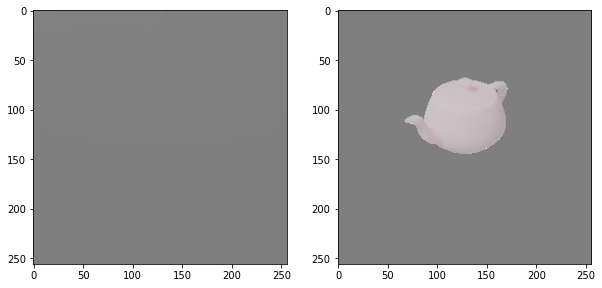

torch.Size([1, 1024, 2, 2])
tensor([[1.3612, 0.0816, 0.3352]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


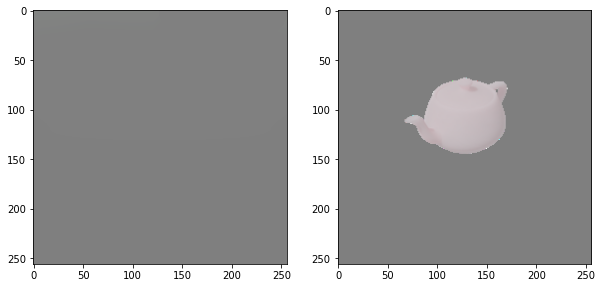

torch.Size([1, 1024, 2, 2])
tensor([[1.3592, 0.0767, 0.3228]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


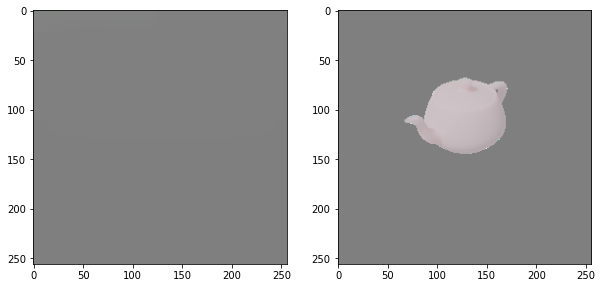

torch.Size([1, 1024, 2, 2])
tensor([[1.3374, 0.0724, 0.3120]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


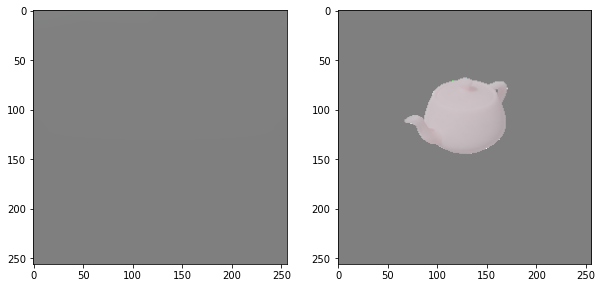

torch.Size([1, 1024, 2, 2])
tensor([[1.3008, 0.0685, 0.3031]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


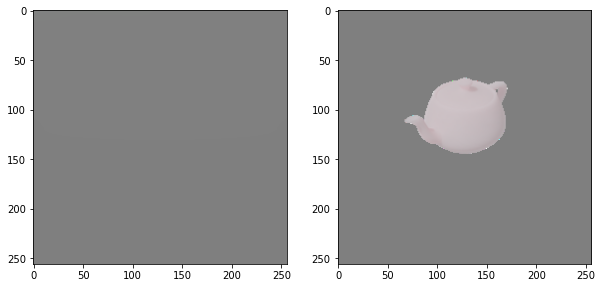

torch.Size([1, 1024, 2, 2])
tensor([[1.2572, 0.0651, 0.2950]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


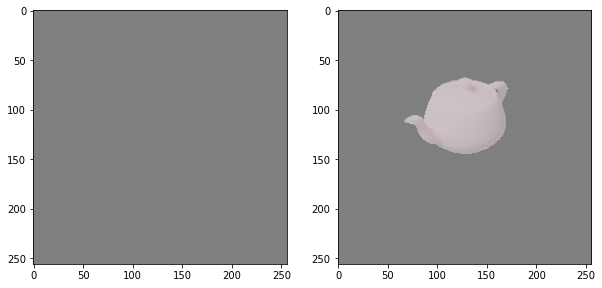

torch.Size([1, 1024, 2, 2])
tensor([[1.2143, 0.0621, 0.2874]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


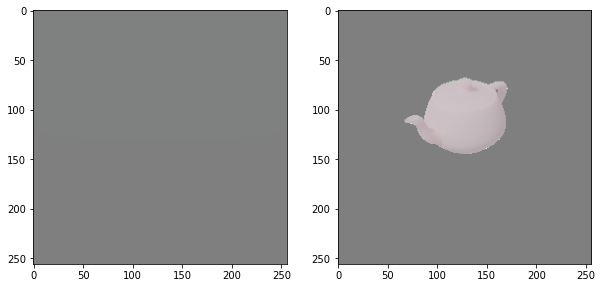

torch.Size([1, 1024, 2, 2])
tensor([[1.1774, 0.0595, 0.2800]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


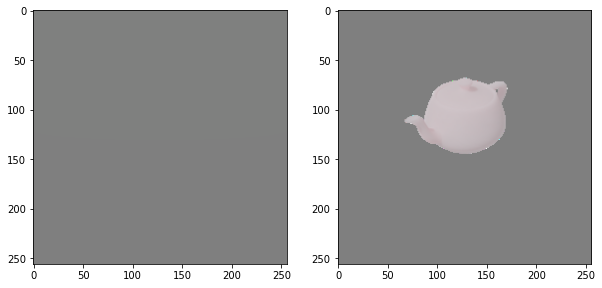

torch.Size([1, 1024, 2, 2])
tensor([[1.1448, 0.0572, 0.2728]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


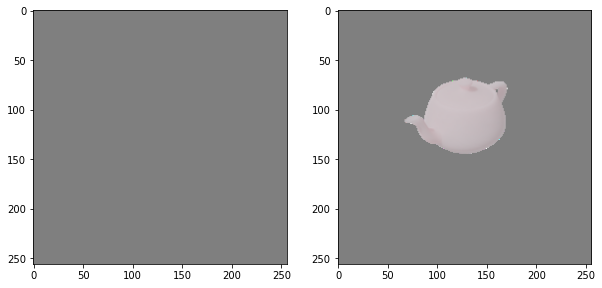

torch.Size([1, 1024, 2, 2])
tensor([[1.1157, 0.0552, 0.2659]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


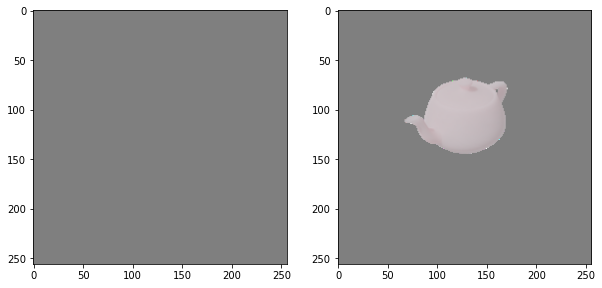

torch.Size([1, 1024, 2, 2])
tensor([[1.0902, 0.0534, 0.2593]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


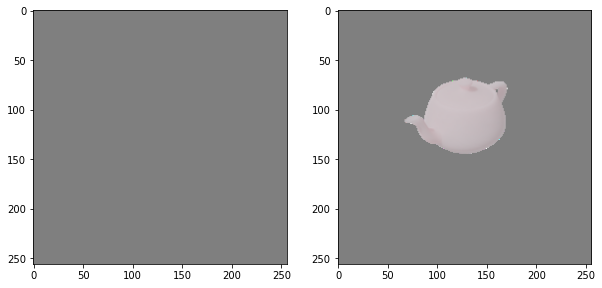

torch.Size([1, 1024, 2, 2])
tensor([[1.0680, 0.0519, 0.2531]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


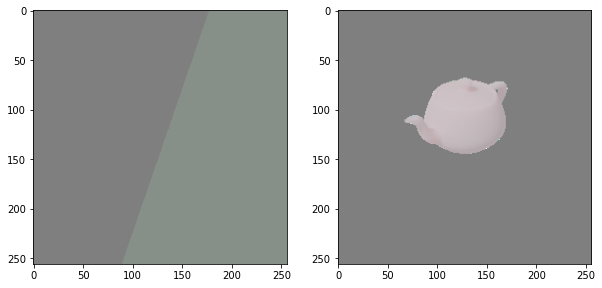

torch.Size([1, 1024, 2, 2])
tensor([[1.2765, 0.0498, 0.2423]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


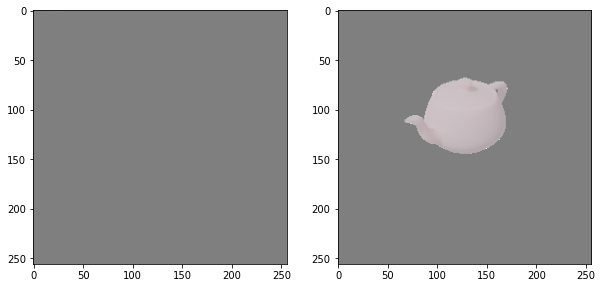

torch.Size([1, 1024, 2, 2])
tensor([[1.4819, 0.0478, 0.2330]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


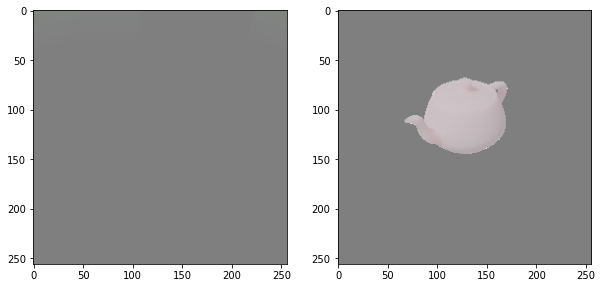

torch.Size([1, 1024, 2, 2])
tensor([[1.6563, 0.0460, 0.2257]], device='cuda:0', grad_fn=<MulBackward0>)
(256, 256, 3)


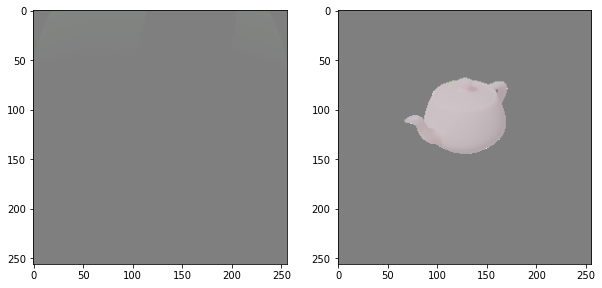

In [299]:
loop = tqdm_notebook(range(50))
for i in loop:
  runningLoss = 0.0

  for k,data in enumerate(renderLoader, 0): 
    optimizer.zero_grad()

    inputImgs= data[0].to(device)

    targetImgs = inputImgs

    outputImgs = model(inputImgs)[:,0:3,:,:] #drop Alpha...

    loss = criterion(outputImgs, targetImgs)

    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
  # End of every 10th epoch
  if i % 1 == 0:
    image = outputImgs[0,0:3,:,:].permute((1,2,0)).detach().squeeze().cpu().numpy()
    print(image.shape)
    image = img_as_ubyte(image)
    writer.append_data(image)

    imcompare(outputImgs[0].detach().squeeze().cpu(), inputImgs[0].squeeze().cpu())
    
writer.close()